## Exercise 7

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import quad
from scipy.stats import rv_continuous
import random

In [2]:
# import the data
data = pd.read_parquet('nss68_total_expenditures.parquet')
data.describe()

,total_value
count,101660.000000
mean,4334.352912
std,2740.356807
min,5.000000
25%,2746.000000
50%,3867.000000
75%,5333.250000
max,213160.000000


#### Question 1

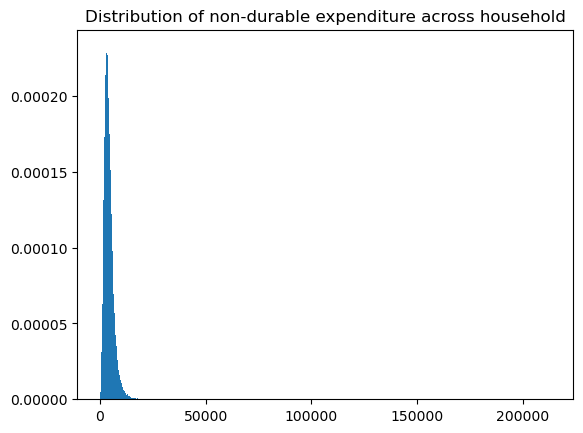

In [3]:
# produce a figure discribing the distribution
plt.hist(data,bins=1000,density=True)
plt.title('Distribution of non-durable expenditure across household')
plt.show()

In [4]:
# gaussian distribution
def kernel_density(X,h,k): #kernel density estimator
    '''
    input:
        X: sample data
        h: bandwidth
        k: kernel
    output:
        a function on x
    '''
    return lambda x:k((x-X)/h).mean()/h

k_g = lambda u:np.exp(-(u**2)/2)/np.sqrt(2*np.pi) #guassian kernel

V = np.linspace(min(data['total_value']),max(data['total_value']),1000) # estimate point

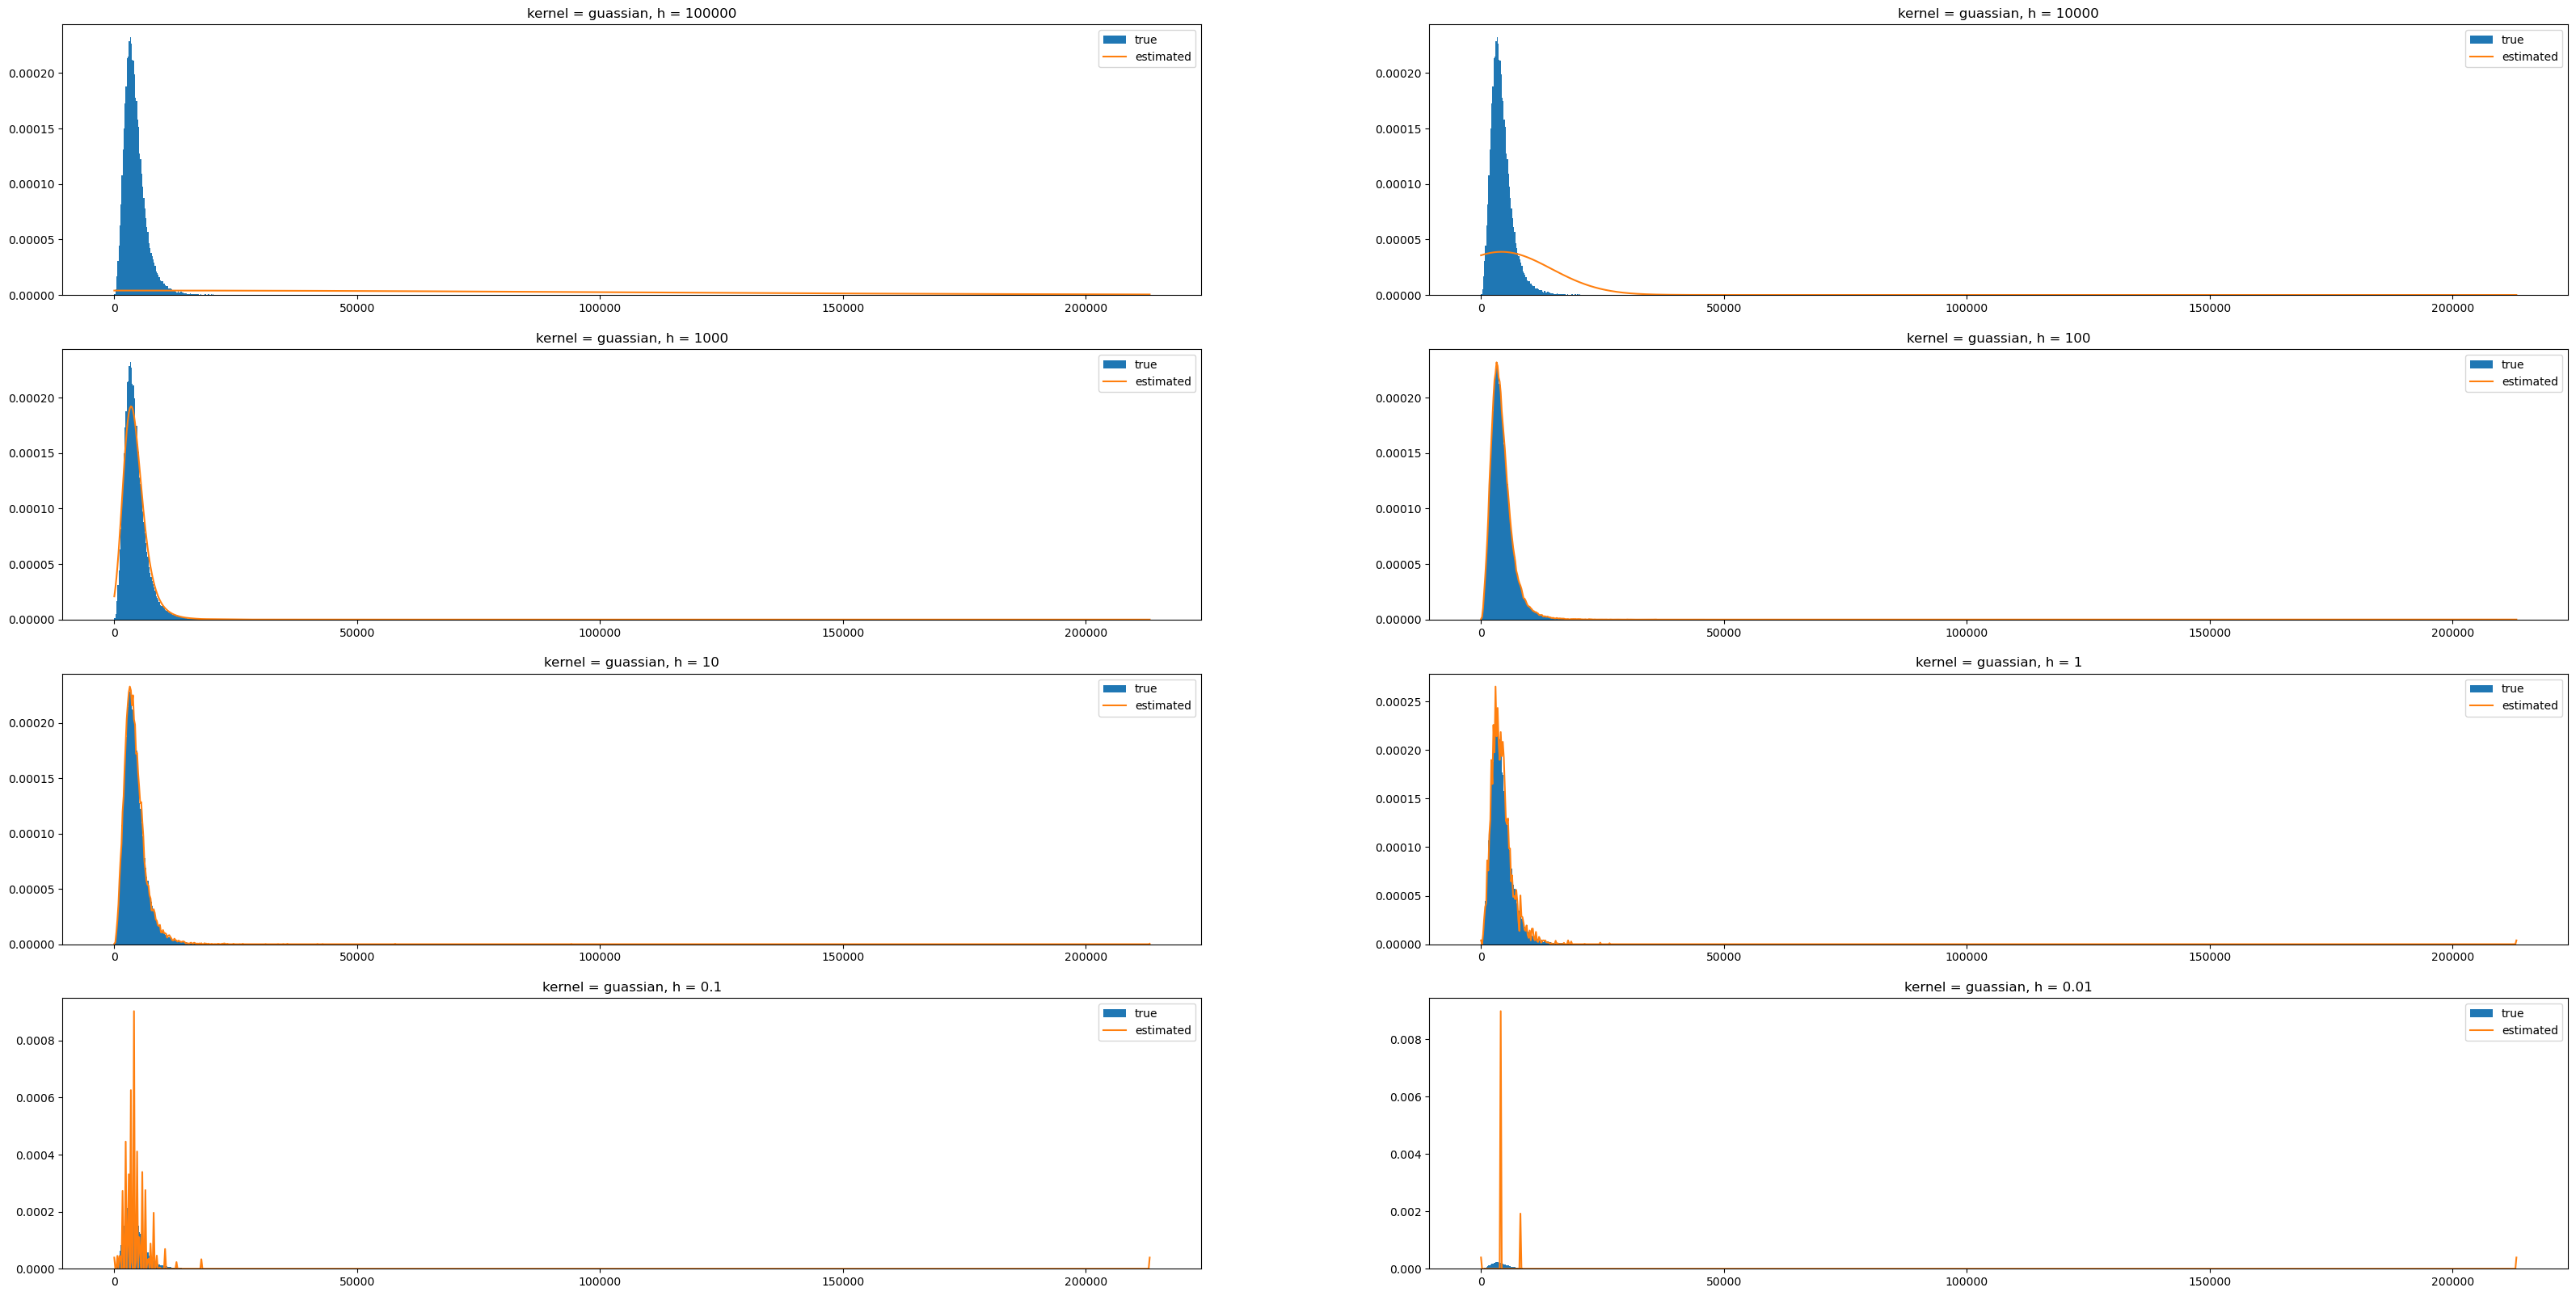

CPU times: total: 37.1 s
Wall time: 1min 20s


In [18]:
%%time
# plot the estimated density by guassian kernel
fig,ax = plt.subplots(4,2,figsize=(40,20))

for i,n in zip(range(8),range(5,-3,-1)):
    fhat = kernel_density(data,10**n,k_g) # estimated pdf
    row = i//2
    col = i%2
    ax[row,col].hist(data,bins=1000,density=True,label='true')
    ax[row,col].plot(V,[fhat(v) for v in V],label='estimated')
    ax[row,col].legend(loc='upper right')
    ax[row,col].set_title('kernel = {0}, h = {1}'.format('guassian',10**n))
plt.show()

Strength: If we choose the right bandwidth, the estimated density would be similar to the true density.</br>
Weakness: (1) If the bandwidth are too big, the bias would be very large. If the bandwidth are too small, the variance would be too large.</br>
          (2) Since the underlying distribution is right-skewed, it would be hard to estimated the distribution with few data.</br>

Now we try to focus on the [20000,30000] to find out the weakness 2 we've mentioned.

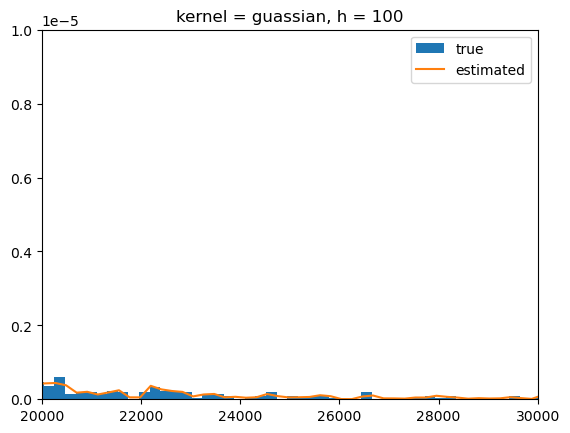

In [56]:
# plot the specific range
fhat = kernel_density(data,100,k_g) # estimated pdf
plt.hist(data,bins=1000,density=True,label='true')
plt.plot(V,[fhat(v) for v in V],label='estimated')
plt.legend(loc='upper right')
plt.title('kernel = {0}, h = {1}'.format('guassian',100))
plt.xlim(20000,30000) # specific x range
plt.ylim(0,0.00001)
plt.show()

Let's try other kernel here.

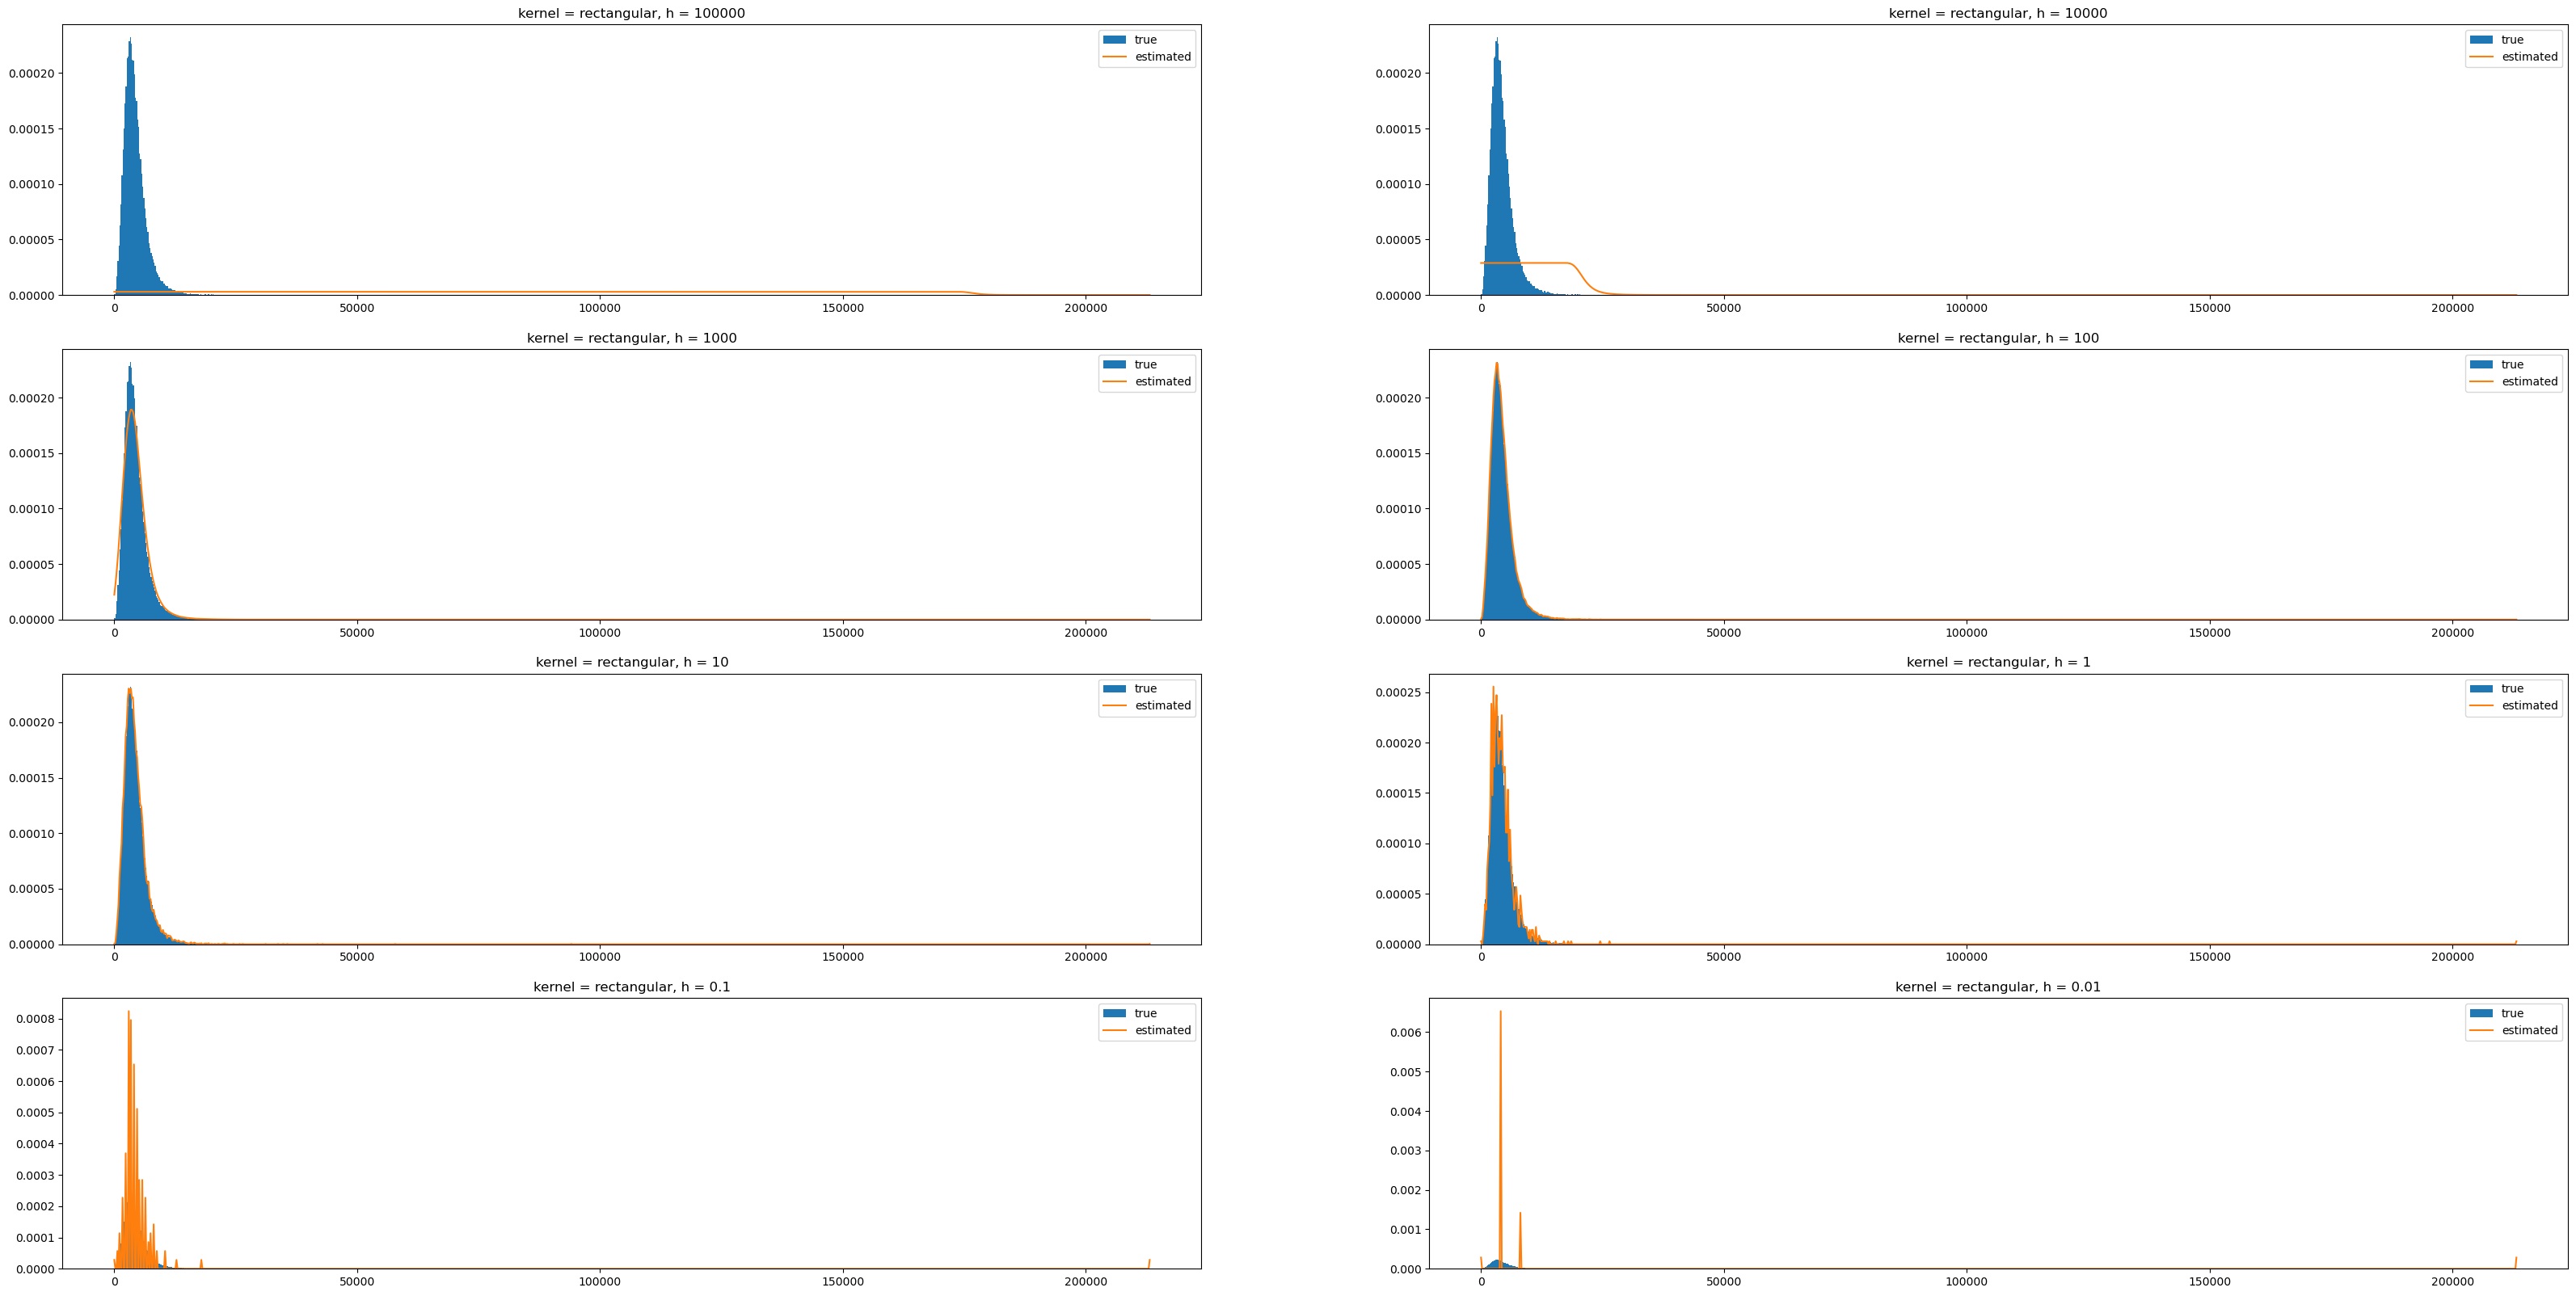

CPU times: total: 16 s
Wall time: 45.4 s


In [21]:
%%time
# plot the estimated density by rectangular kernel
fig,ax = plt.subplots(4,2,figsize=(40,20))
k_r = lambda u:(np.abs(u)<np.sqrt(3))/(2*np.sqrt(3))

for i,n in zip(range(8),range(5,-3,-1)):
    fhat = kernel_density(data,10**n,k_r) # estimated pdf
    row = i//2
    col = i%2
    ax[row,col].hist(data,bins=1000,density=True,label='true')
    ax[row,col].plot(V,[fhat(v) for v in V],label='estimated')
    ax[row,col].legend(loc='upper right')
    ax[row,col].set_title('kernel = {0}, h = {1}'.format('rectangular',10**n))
plt.show()

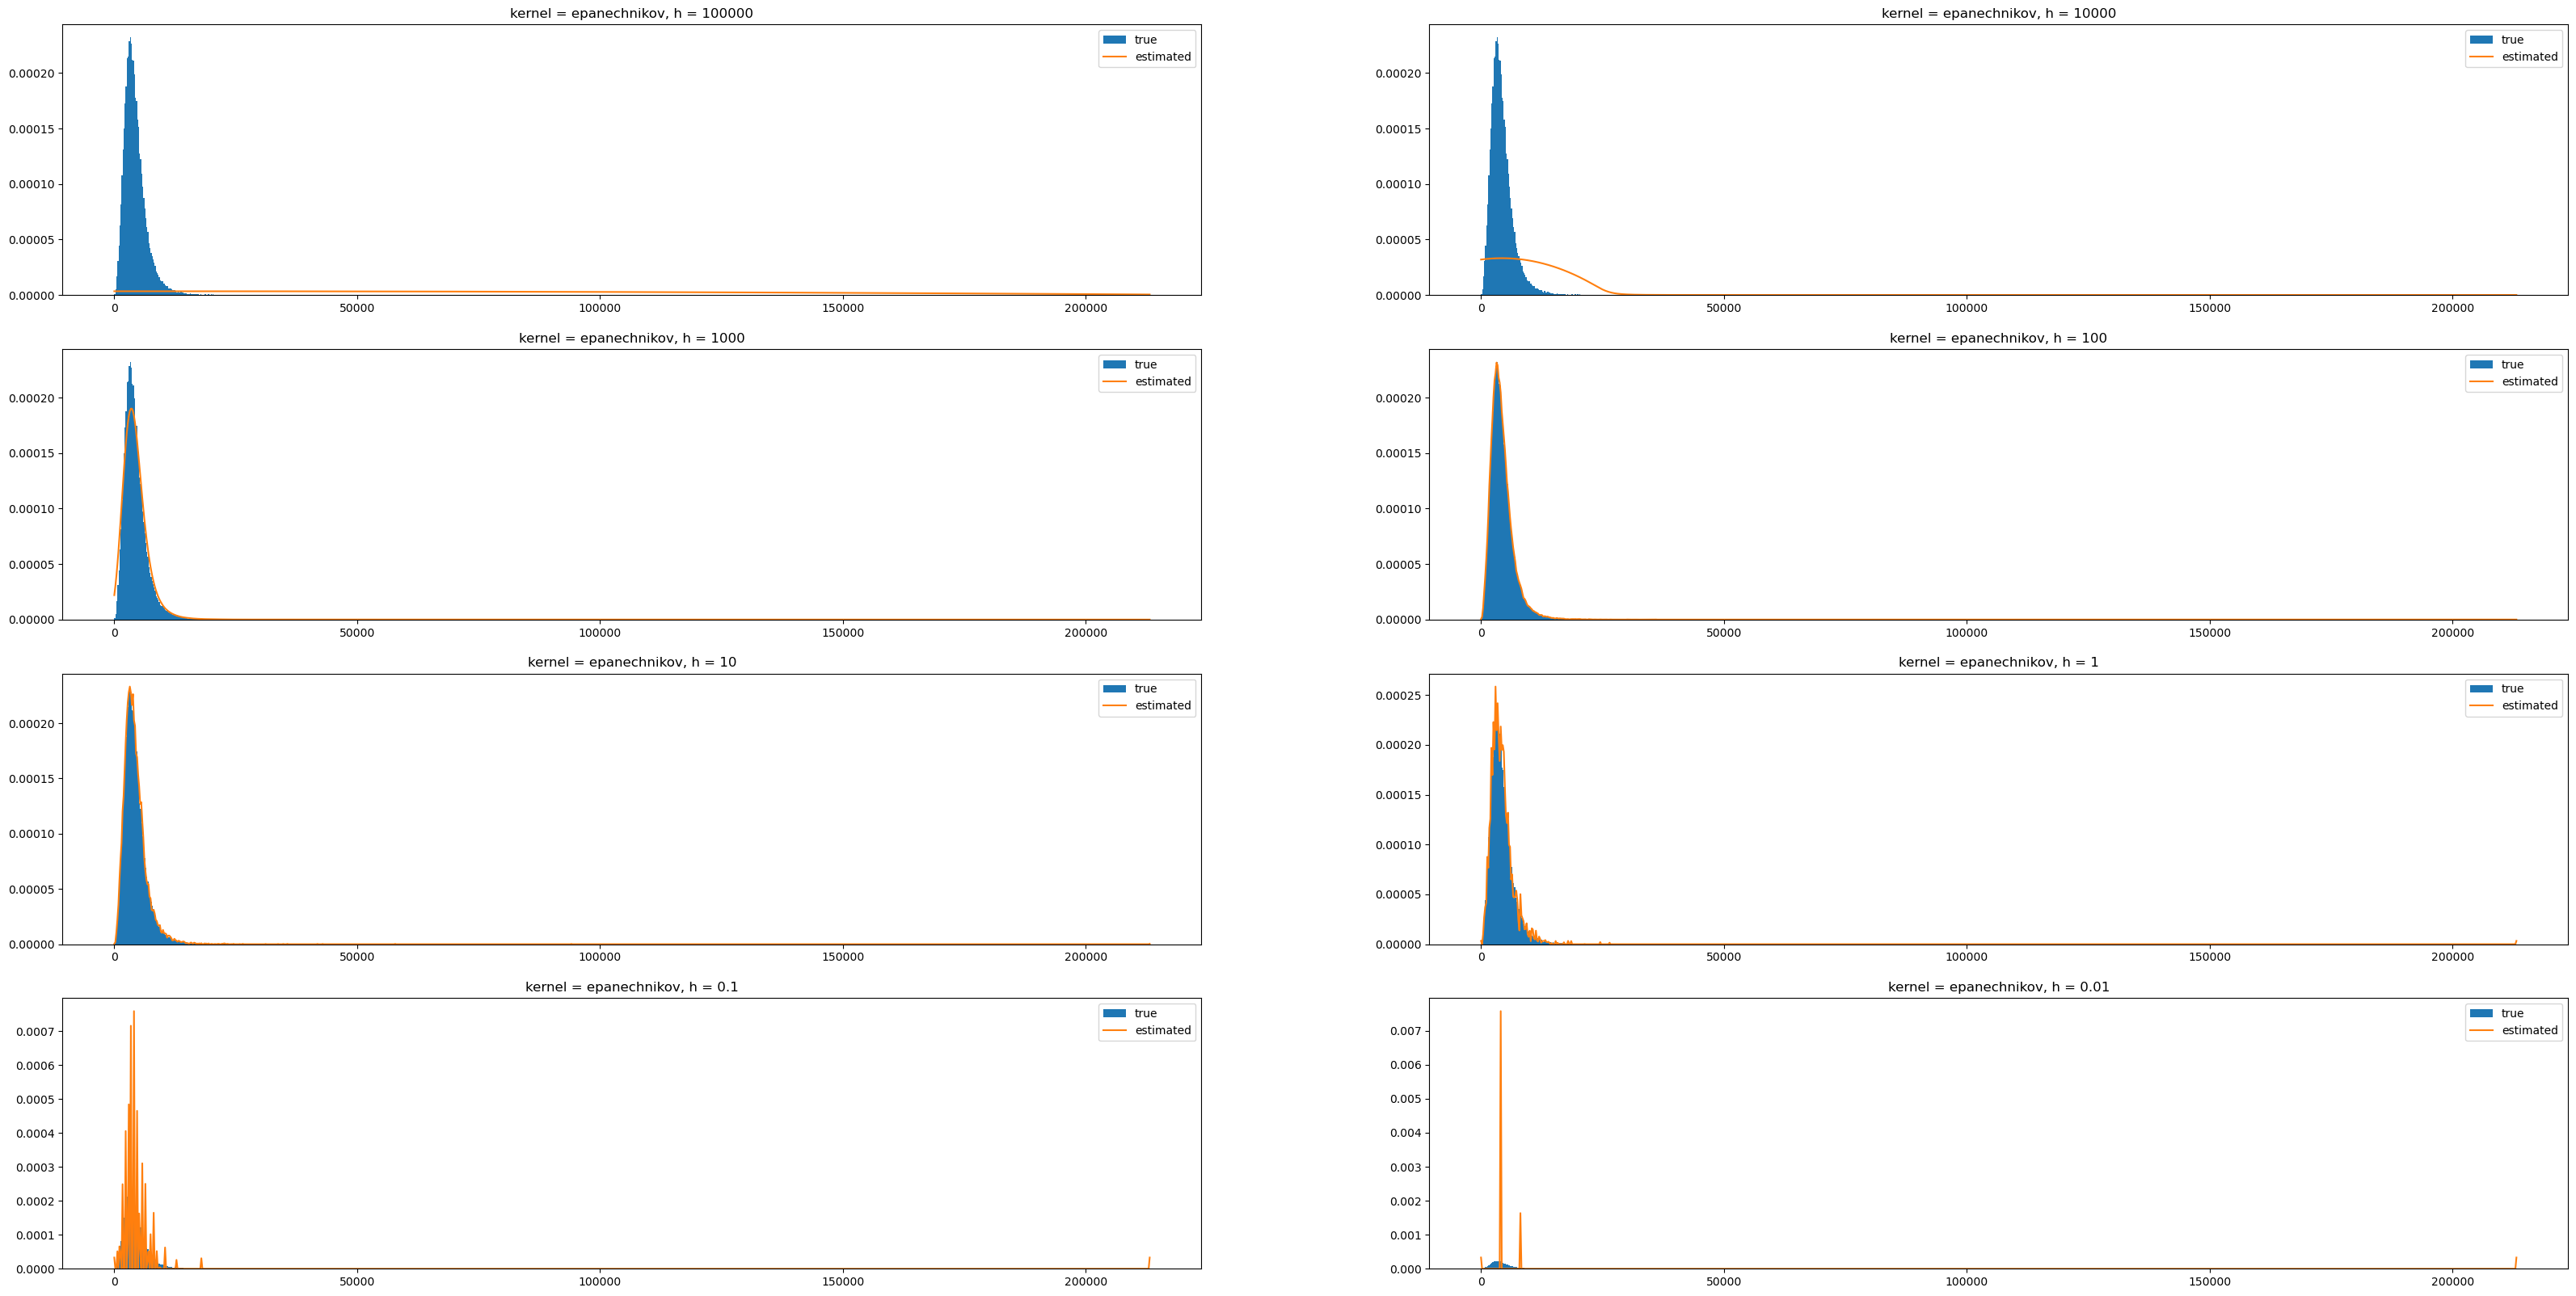

CPU times: total: 15.5 s
Wall time: 47.2 s


In [22]:
%%time
# plot the estimated density by epanechnikov kernel
fig,ax = plt.subplots(4,2,figsize=(40,20))
k_e = lambda u:(np.abs(u)<np.sqrt(5))*(3/(4*np.sqrt(5)))*(1-np.power(u,2)/5)

for i,n in zip(range(8),range(5,-3,-1)):
    fhat = kernel_density(data,10**n,k_e) # estimated pdf
    row = i//2
    col = i%2
    ax[row,col].hist(data,bins=1000,density=True,label='true')
    ax[row,col].plot(V,[fhat(v) for v in V],label='estimated')
    ax[row,col].legend(loc='upper right')
    ax[row,col].set_title('kernel = {0}, h = {1}'.format('epanechnikov',10**n))
plt.show()

We could see the estimation is best when bandwidth equals to 100, now we try to focus on the range with less data using different kernel.

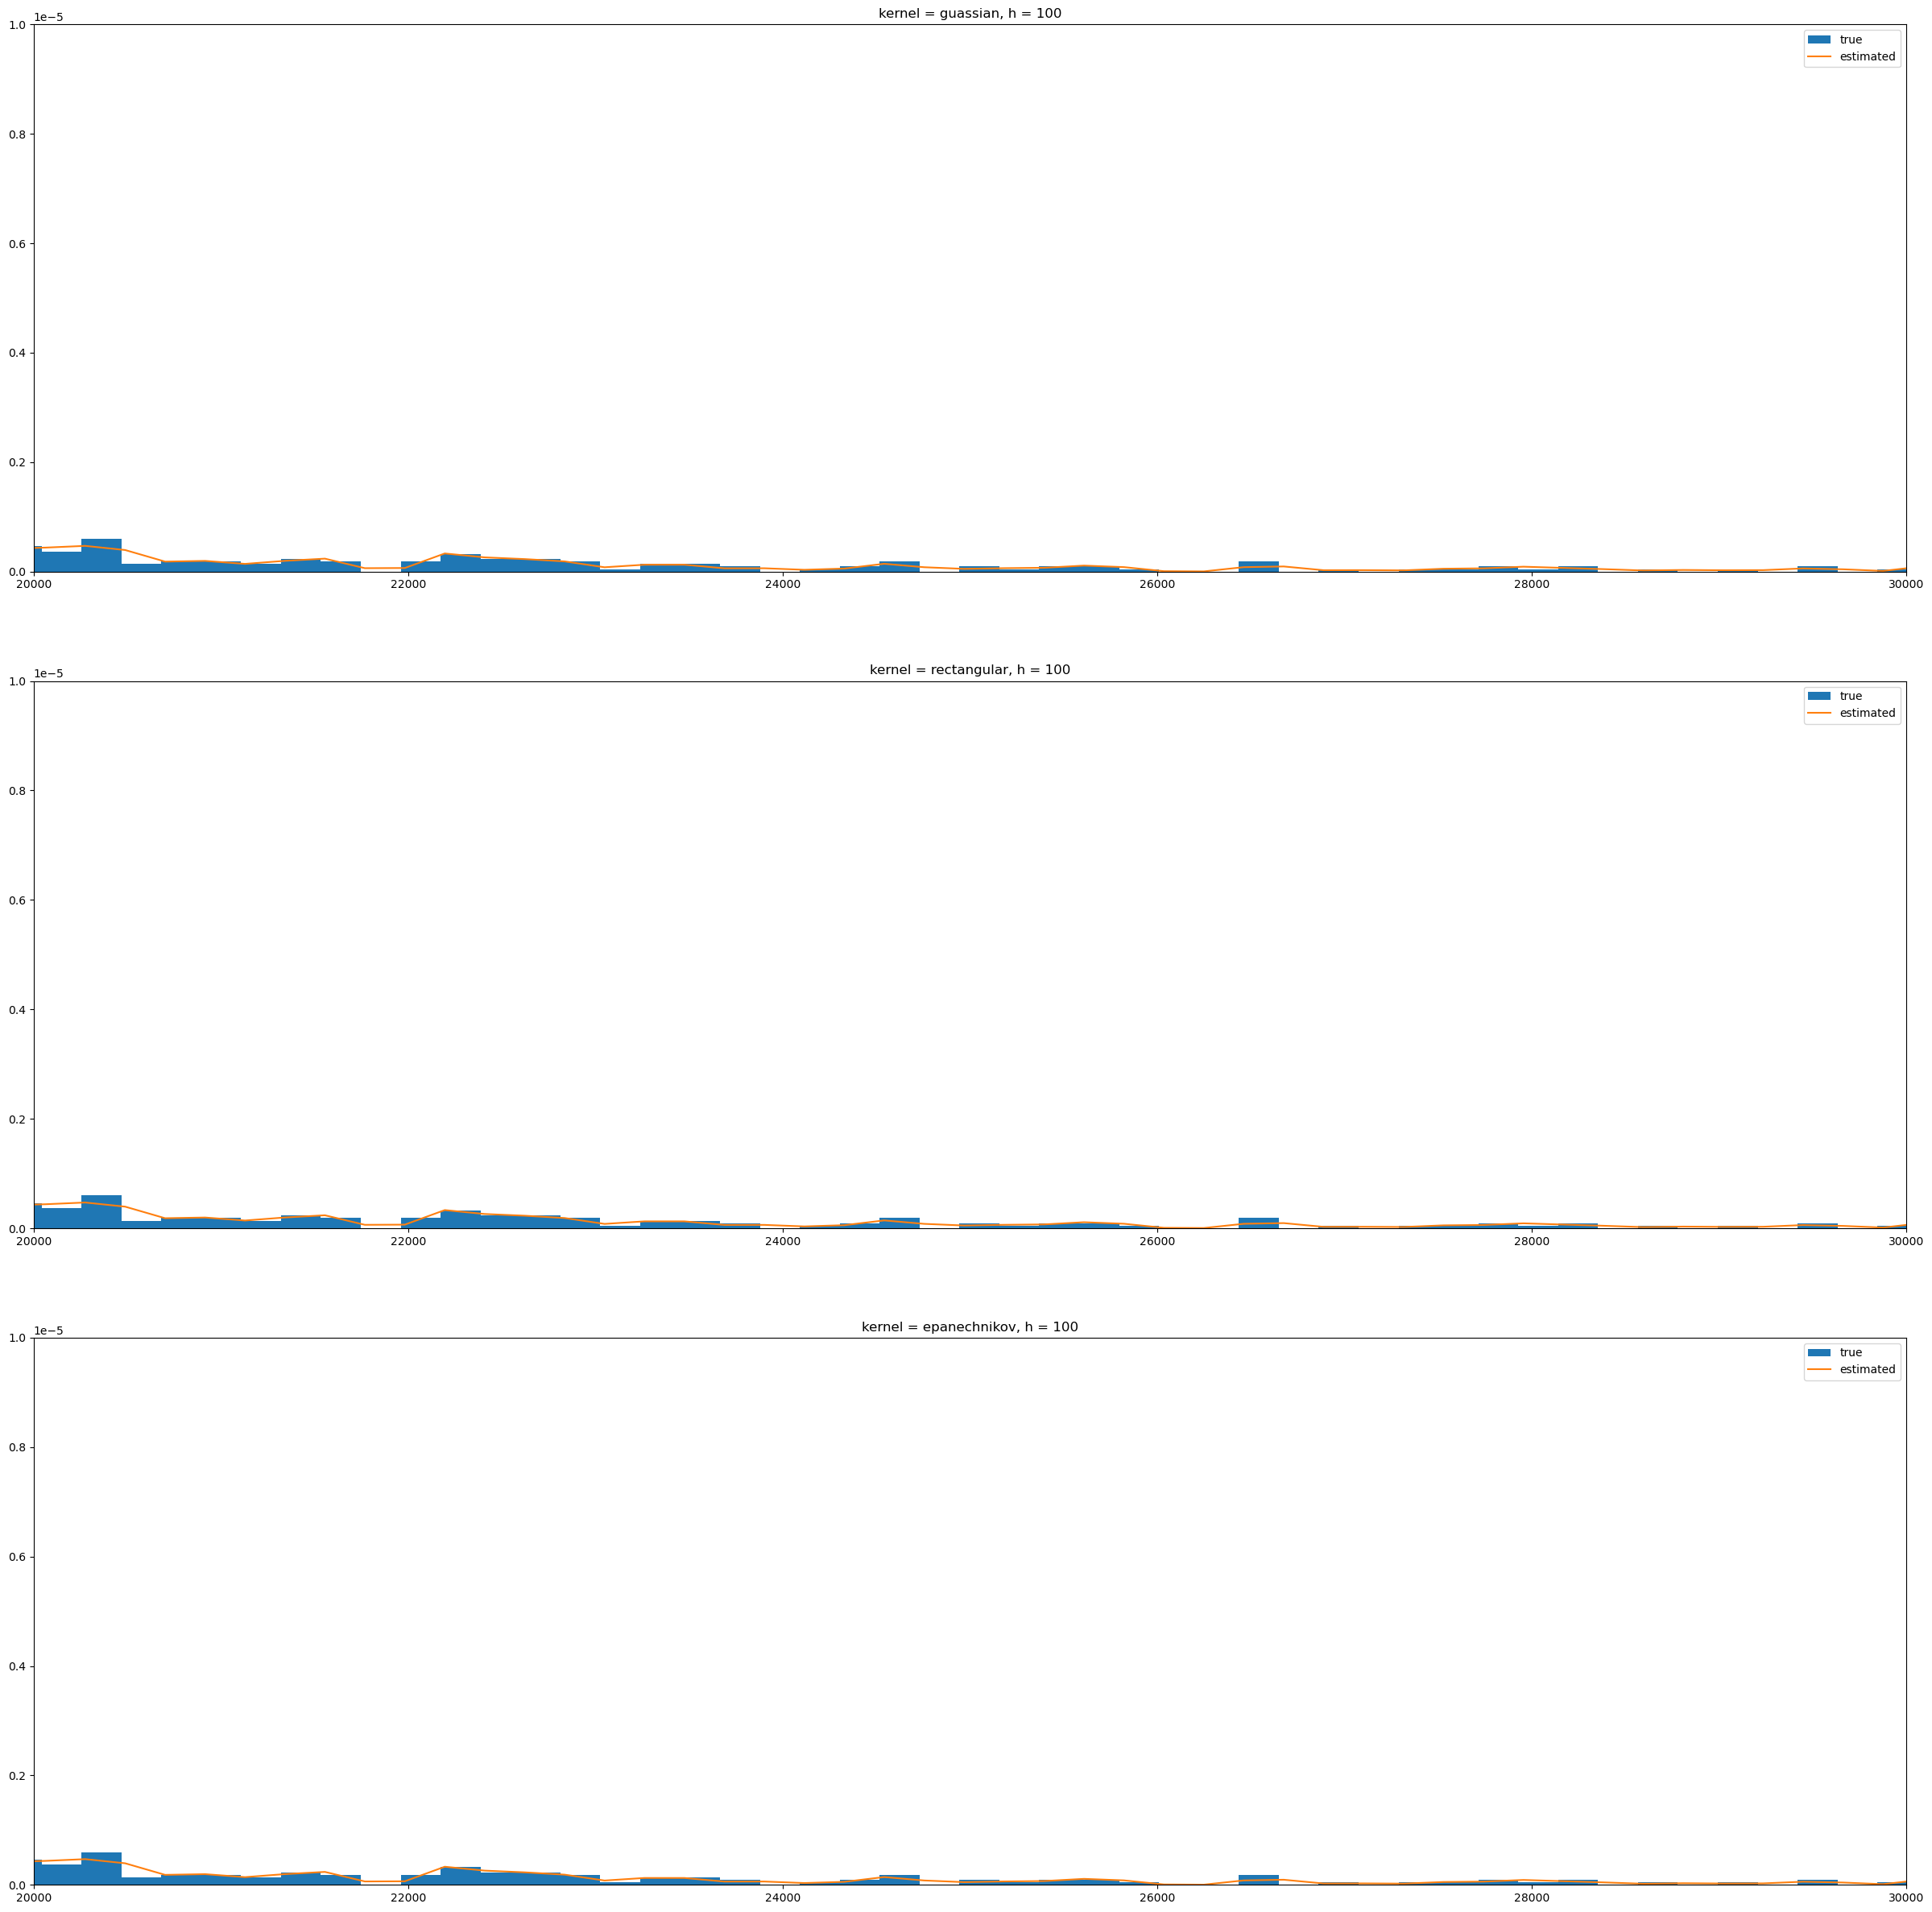

CPU times: total: 9.17 s
Wall time: 16.1 s


In [57]:
%%time
# plot the estimated density with best 
fig,ax = plt.subplots(3,1,figsize=(30,30))

for i,n,name in zip(range(3),[k_g,k_r,k_e],['guassian','rectangular','epanechnikov']):
    fhat = kernel_density(data,100,k_e) # estimated pdf
    ax[i].hist(data,bins=1000,density=True,label='true')
    ax[i].plot(V,[fhat(v) for v in V],label='estimated')
    ax[i].legend(loc='upper right')
    ax[i].set_title('kernel = {0}, h = {1}'.format(name,100))
    ax[i].set_xlim(20000,30000) # specific x range, there is less data in this range
    ax[i].set_ylim(0,0.00001)
plt.show()

We could see that since the weakness is caused by the lack of data, which is determined by its skewness, we couldn't further optimize our estimation simply by change the kernel or bandwidth.

#### Question 2
Since we have:
$$
\int \hat{f}^h(x)dx = \int \hat{f}^h(\exp(y))|{\frac{dx}{dy}}| dy
$$
We could estimate the density of log expenditure as follows.

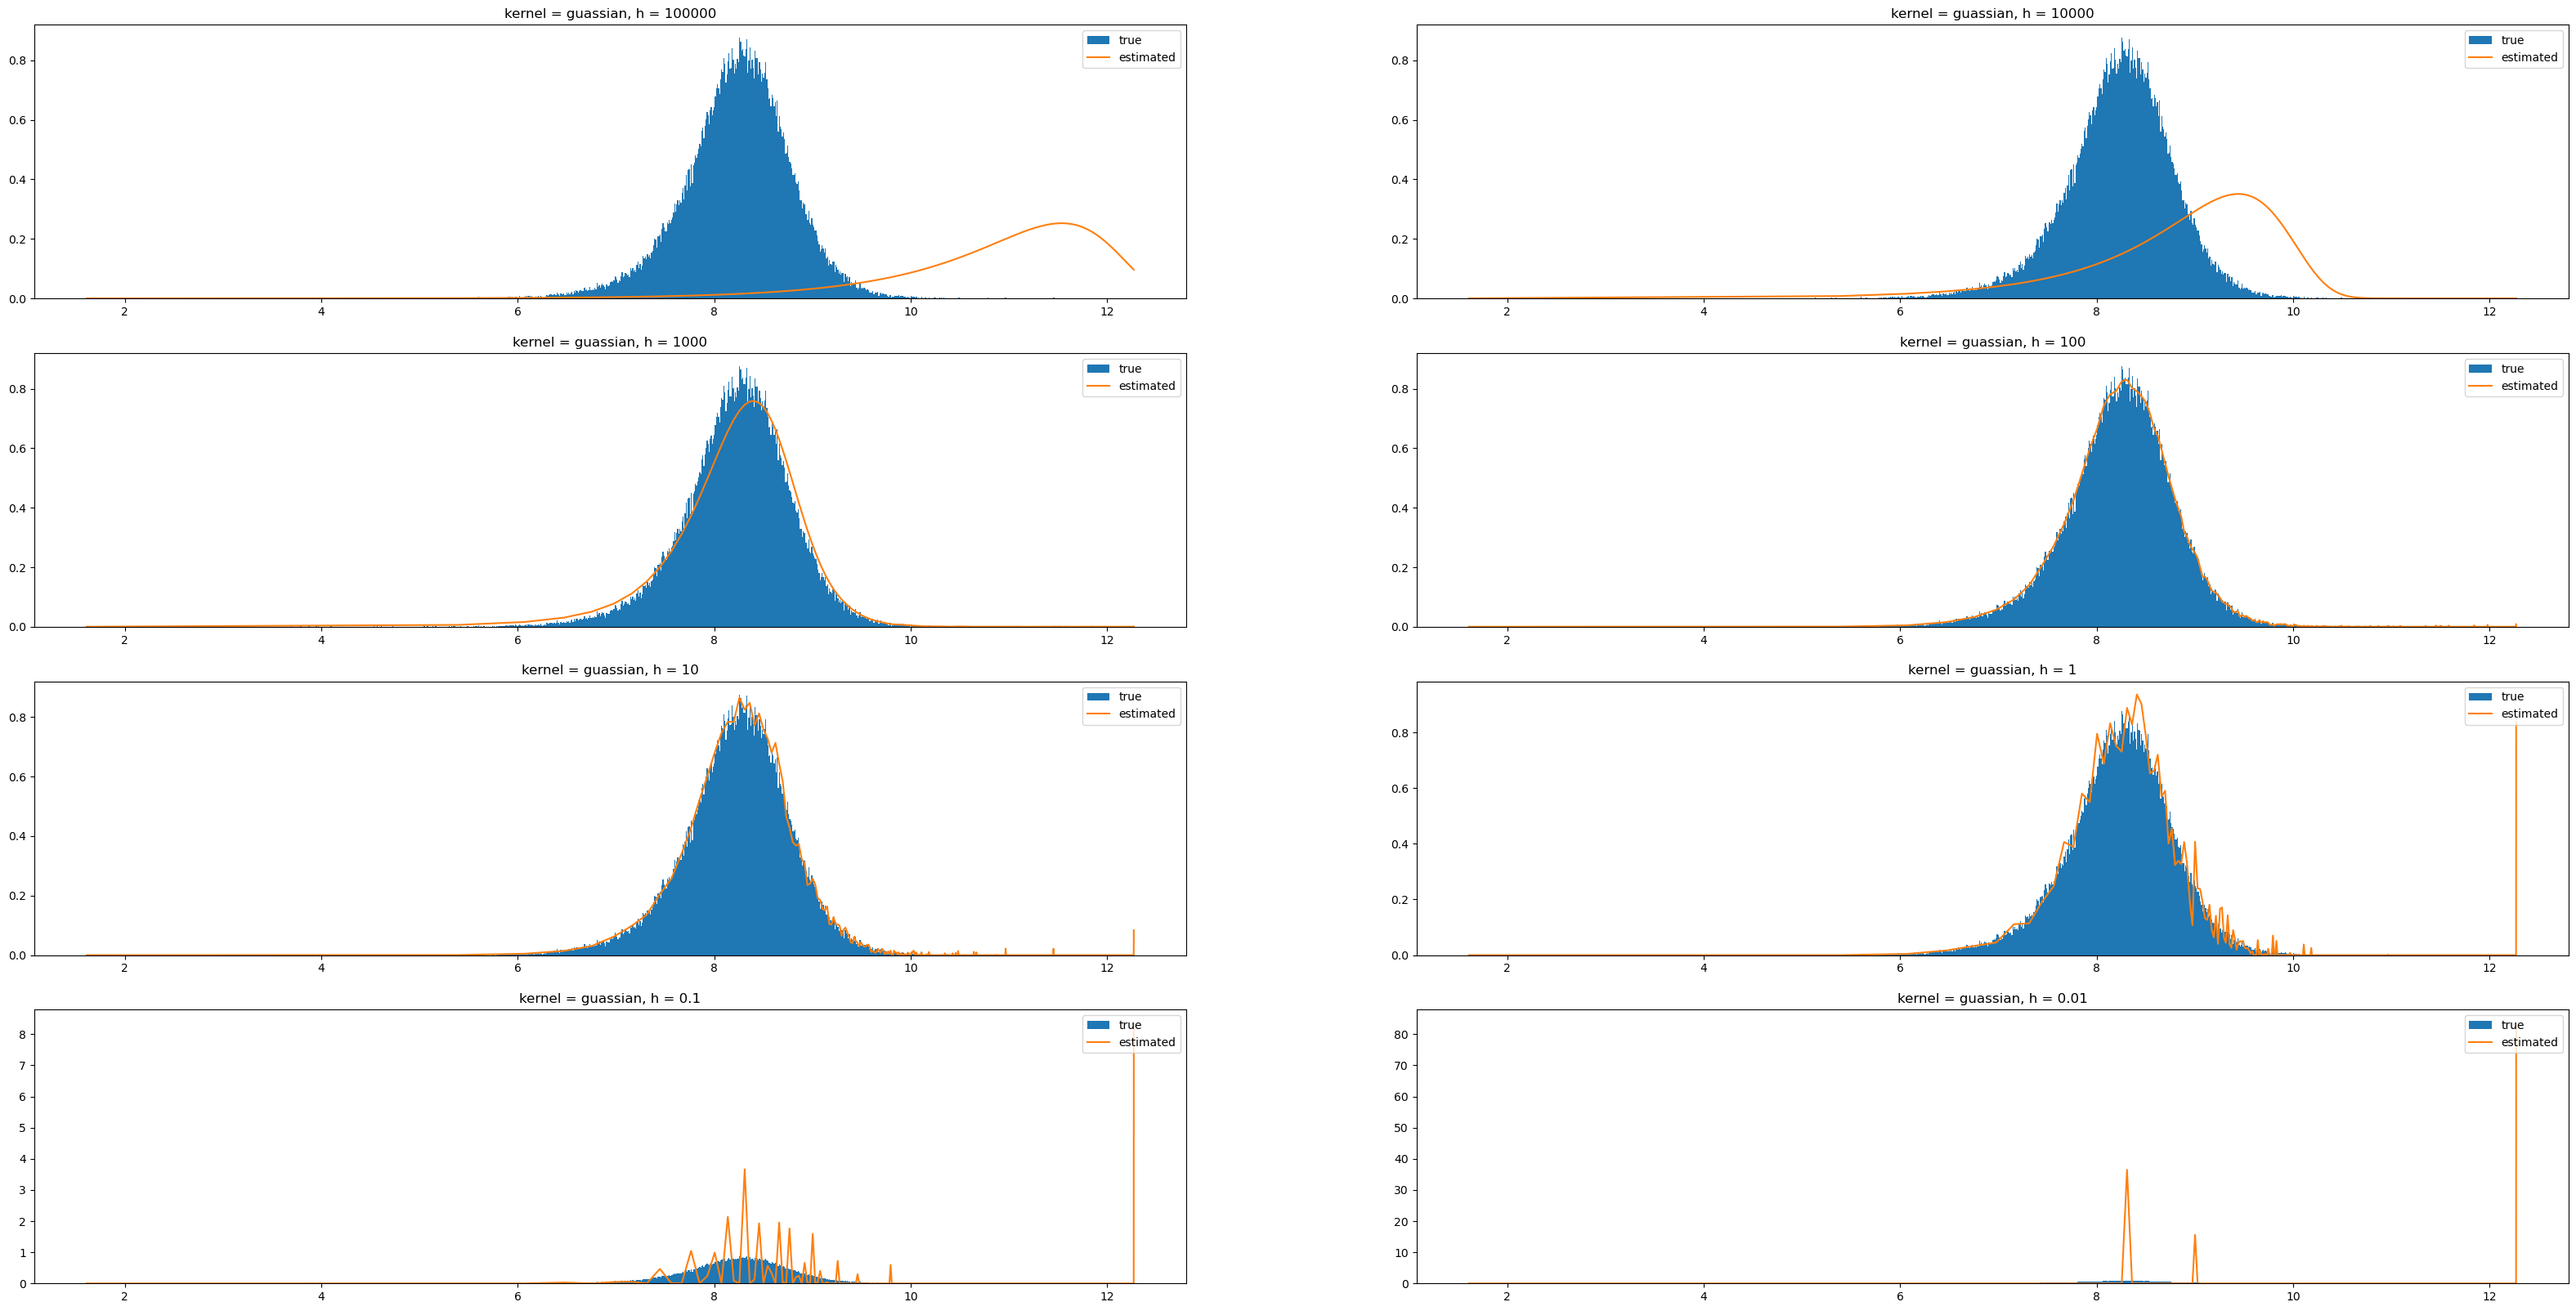

CPU times: total: 43.7 s
Wall time: 1min 25s


In [23]:
%%time
# plot the estimated density by guassian kernel
fig,ax = plt.subplots(4,2,figsize=(40,20))
V = np.linspace(min(data['total_value']),max(data['total_value']),1000) # estimate point

for i,n in zip(range(8),range(5,-3,-1)):
    fhat = kernel_density(data,10**n,k_g) # estimated pdf
    row = i//2
    col = i%2
    ax[row,col].hist(np.log(data),bins=1000,density=True,label='true')
    ax[row,col].plot(np.log(V),[fhat(np.exp(v))*np.exp(v) for v in np.log(V)],label='estimated')
    ax[row,col].legend(loc='upper right')
    ax[row,col].set_title('kernel = {0}, h = {1}'.format('guassian',10**n))
plt.show()

#### Question 3

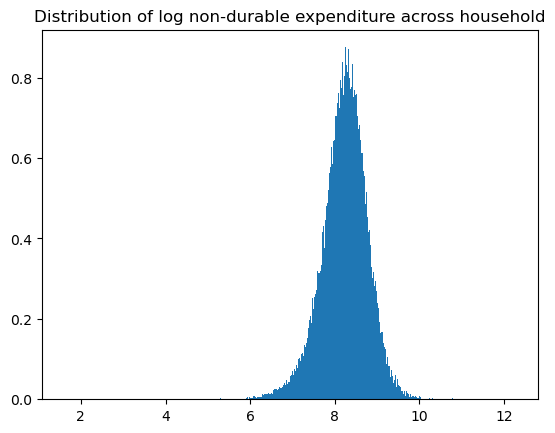

In [8]:
# get the log expenditures
log_data = np.log(data)

# produce a figure discribing the distribution
plt.hist(log_data,bins=1000,density=True)
plt.title('Distribution of log non-durable expenditure across household')
plt.show()

Let's plot the estimated density through jacobian way and direct way in the same figure.

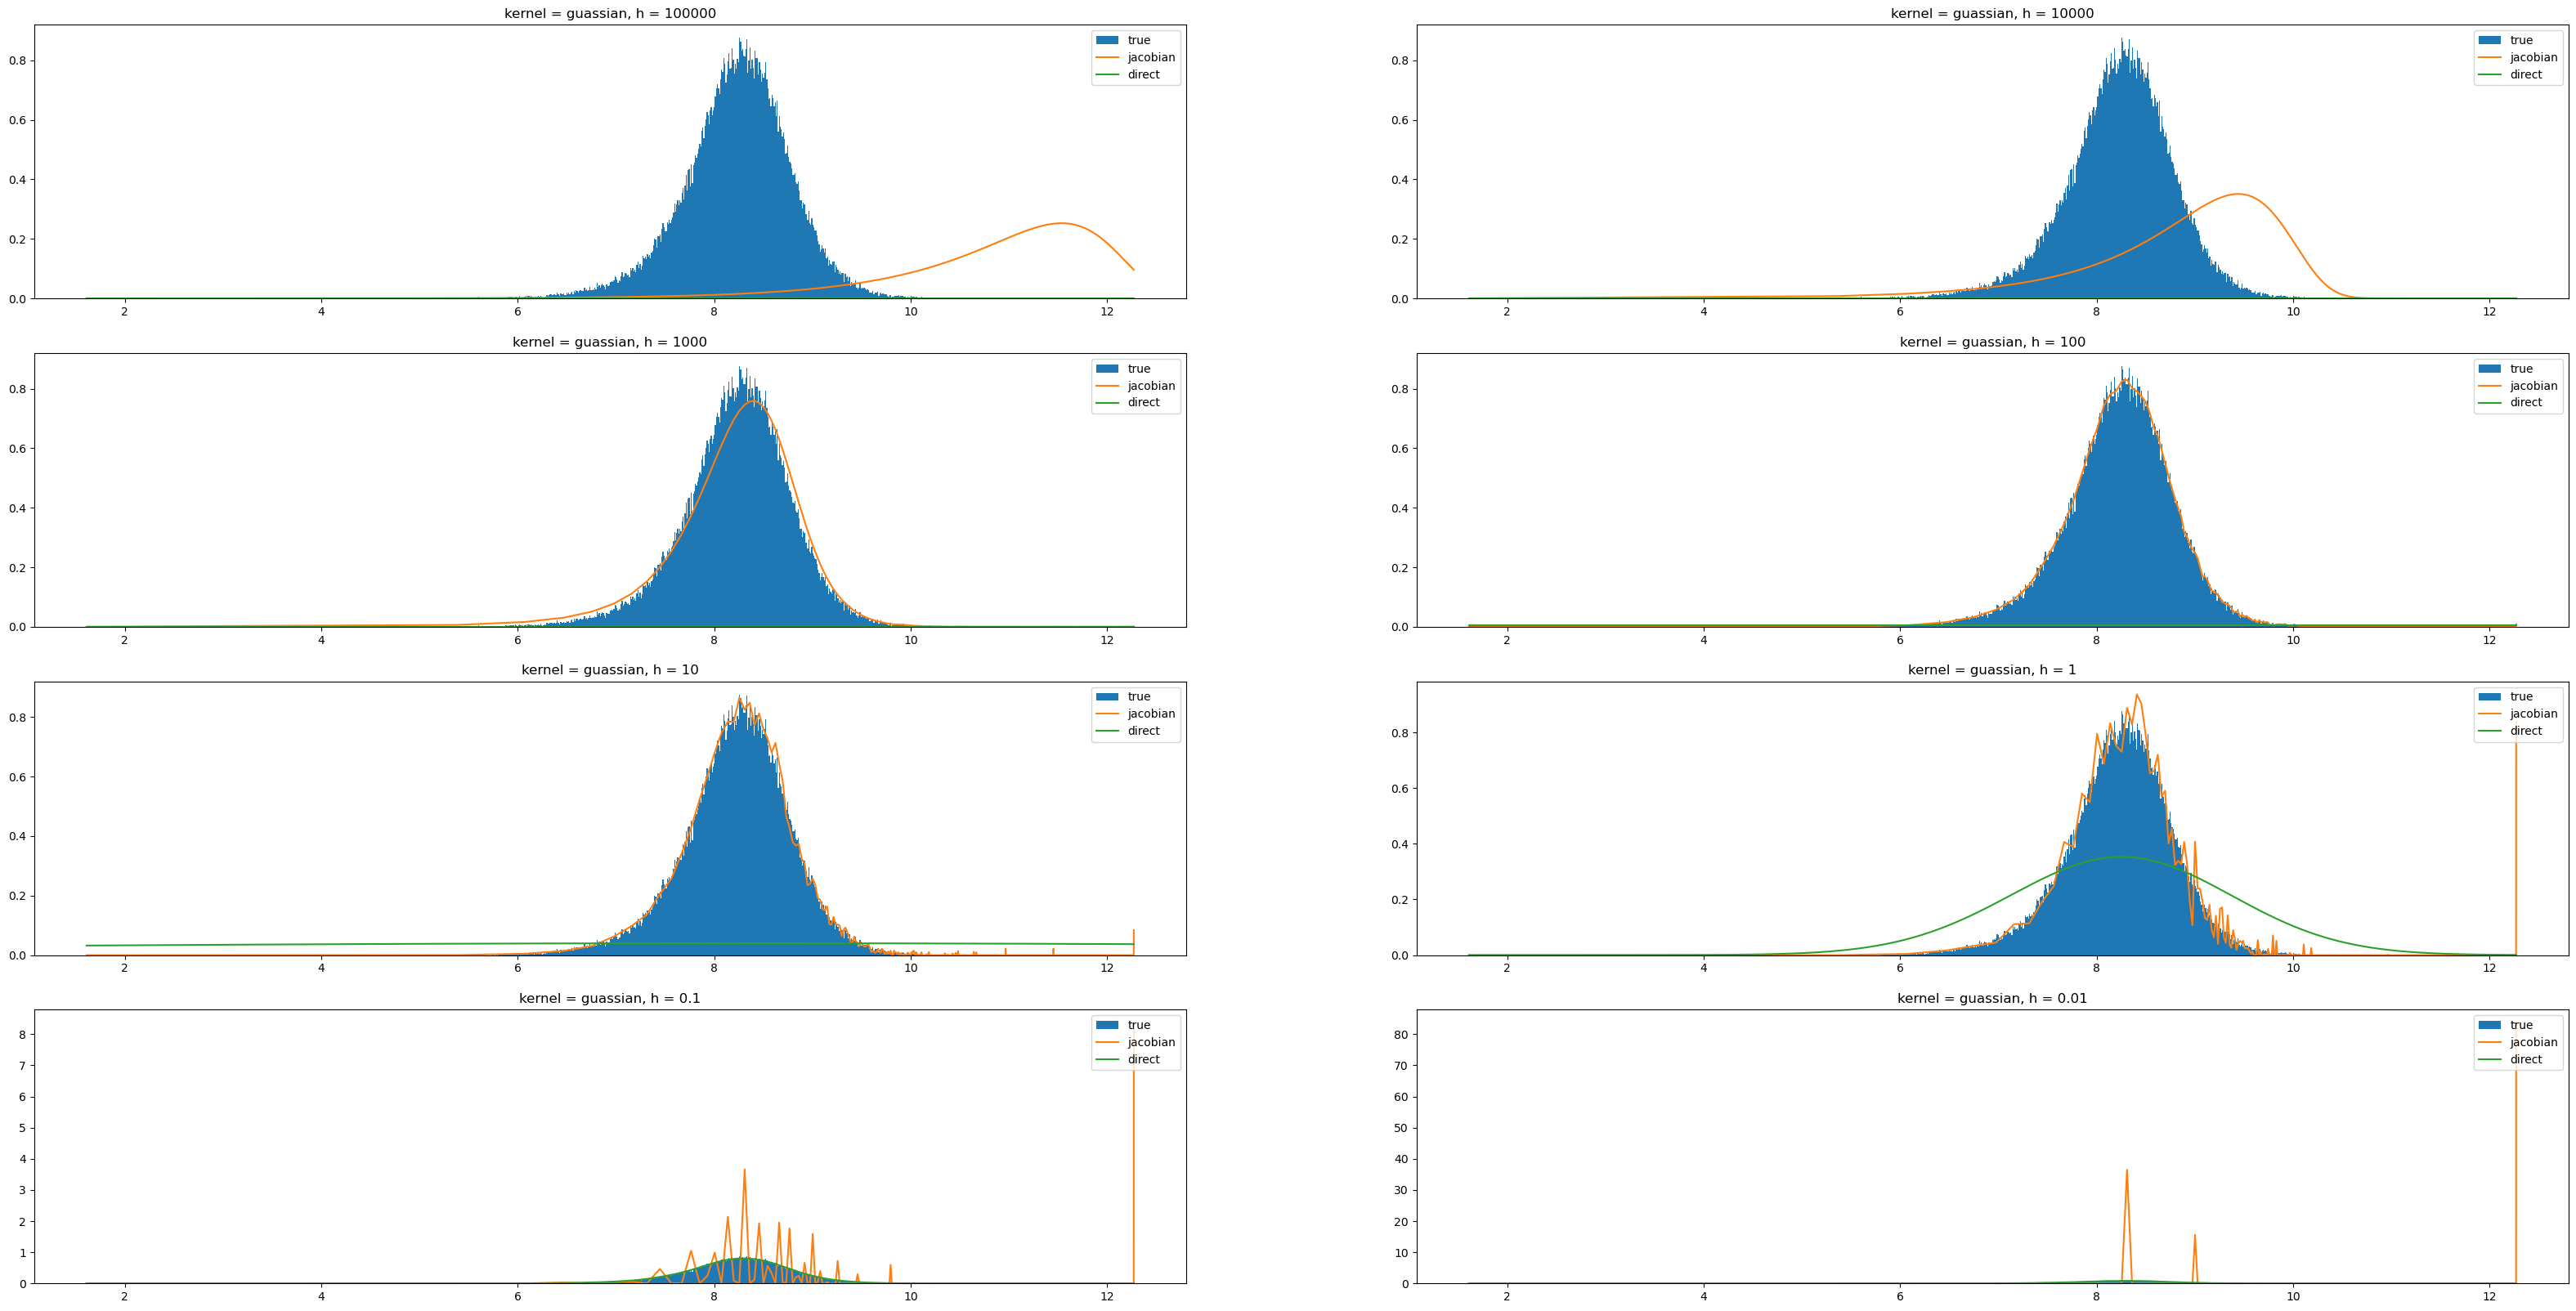

CPU times: total: 1min
Wall time: 2min 8s


In [24]:
%%time
# plot the estimated density by guassian kernel
fig,ax = plt.subplots(4,2,figsize=(40,20))
V1 = np.linspace(min(data['total_value']),max(data['total_value']),1000) # estimate point for jacobian estimation
V2 = np.linspace(min(log_data['total_value']),max(log_data['total_value']),1000) # estimate point for direct estimation

for i,n in zip(range(8),range(5,-3,-1)):
    fhat = kernel_density(data,10**n,k_g) # estimated expenditure pdf
    fhat_log = kernel_density(log_data,10**n,k_g) #estimated log expenditure pdf
    row = i//2
    col = i%2
    ax[row,col].hist(np.log(data),bins=1000,density=True,label='true') # true density of log expenditure
    ax[row,col].plot(np.log(V1),[fhat(np.exp(v))*np.exp(v) for v in np.log(V1)],label='jacobian') # estimated density of log density through jacobian
    ax[row,col].plot(V2,[fhat_log(v) for v in V2],label='direct') # estimated density of log density directly
    ax[row,col].legend(loc='upper right')
    ax[row,col].set_title('kernel = {0}, h = {1}'.format('guassian',10**n))
plt.show()

Compared the result from two ways we could see:</br>
(1) The "best" bandwidth is different between these two methods. For Jacobian way the best one is 100 while for direct way the best one is 0.1.</br>
The reason for this is because the random sample we use are different, we still use the original data to estimate in the jacobian way while we use the "log data" to estimate in the direct way, which has smaller distance between each sample point.</br>
(2) The bias and the variance would be much bigger if we choose a poor bandwidth when we use "inverse jacobian rule" to estimate the density, also, the estimated distribution from jacobian way would be more likely to be influenced by the outliers.

## Exercise 8
Let's use a distribution similar to wiggly to explore it! We call it "wave" here.

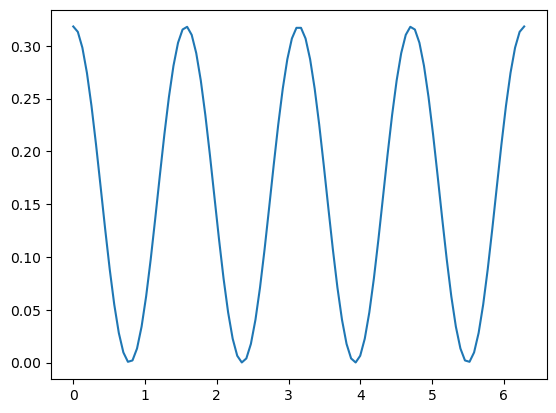

In [88]:
# generation the distribution
class wave_gen(rv_continuous):

    """wave distribution"""

    def _pdf(self, x):
        d = self.b - self.a
        return (np.cos(x*4*2*np.pi/d) + 1)/(self.b - self.a)

wave = wave_gen(a=0.,b=2*np.pi,name='wave')
x = wave()
f = x.pdf # true pdf

# plot the pdf
V = np.linspace(0,2*np.pi,100) # get the value at these points
plt.plot(V,[f(v) for v in V])
plt.show()

Now let's plot the density and bias, and compare the result when we use different density to estimate the bias.

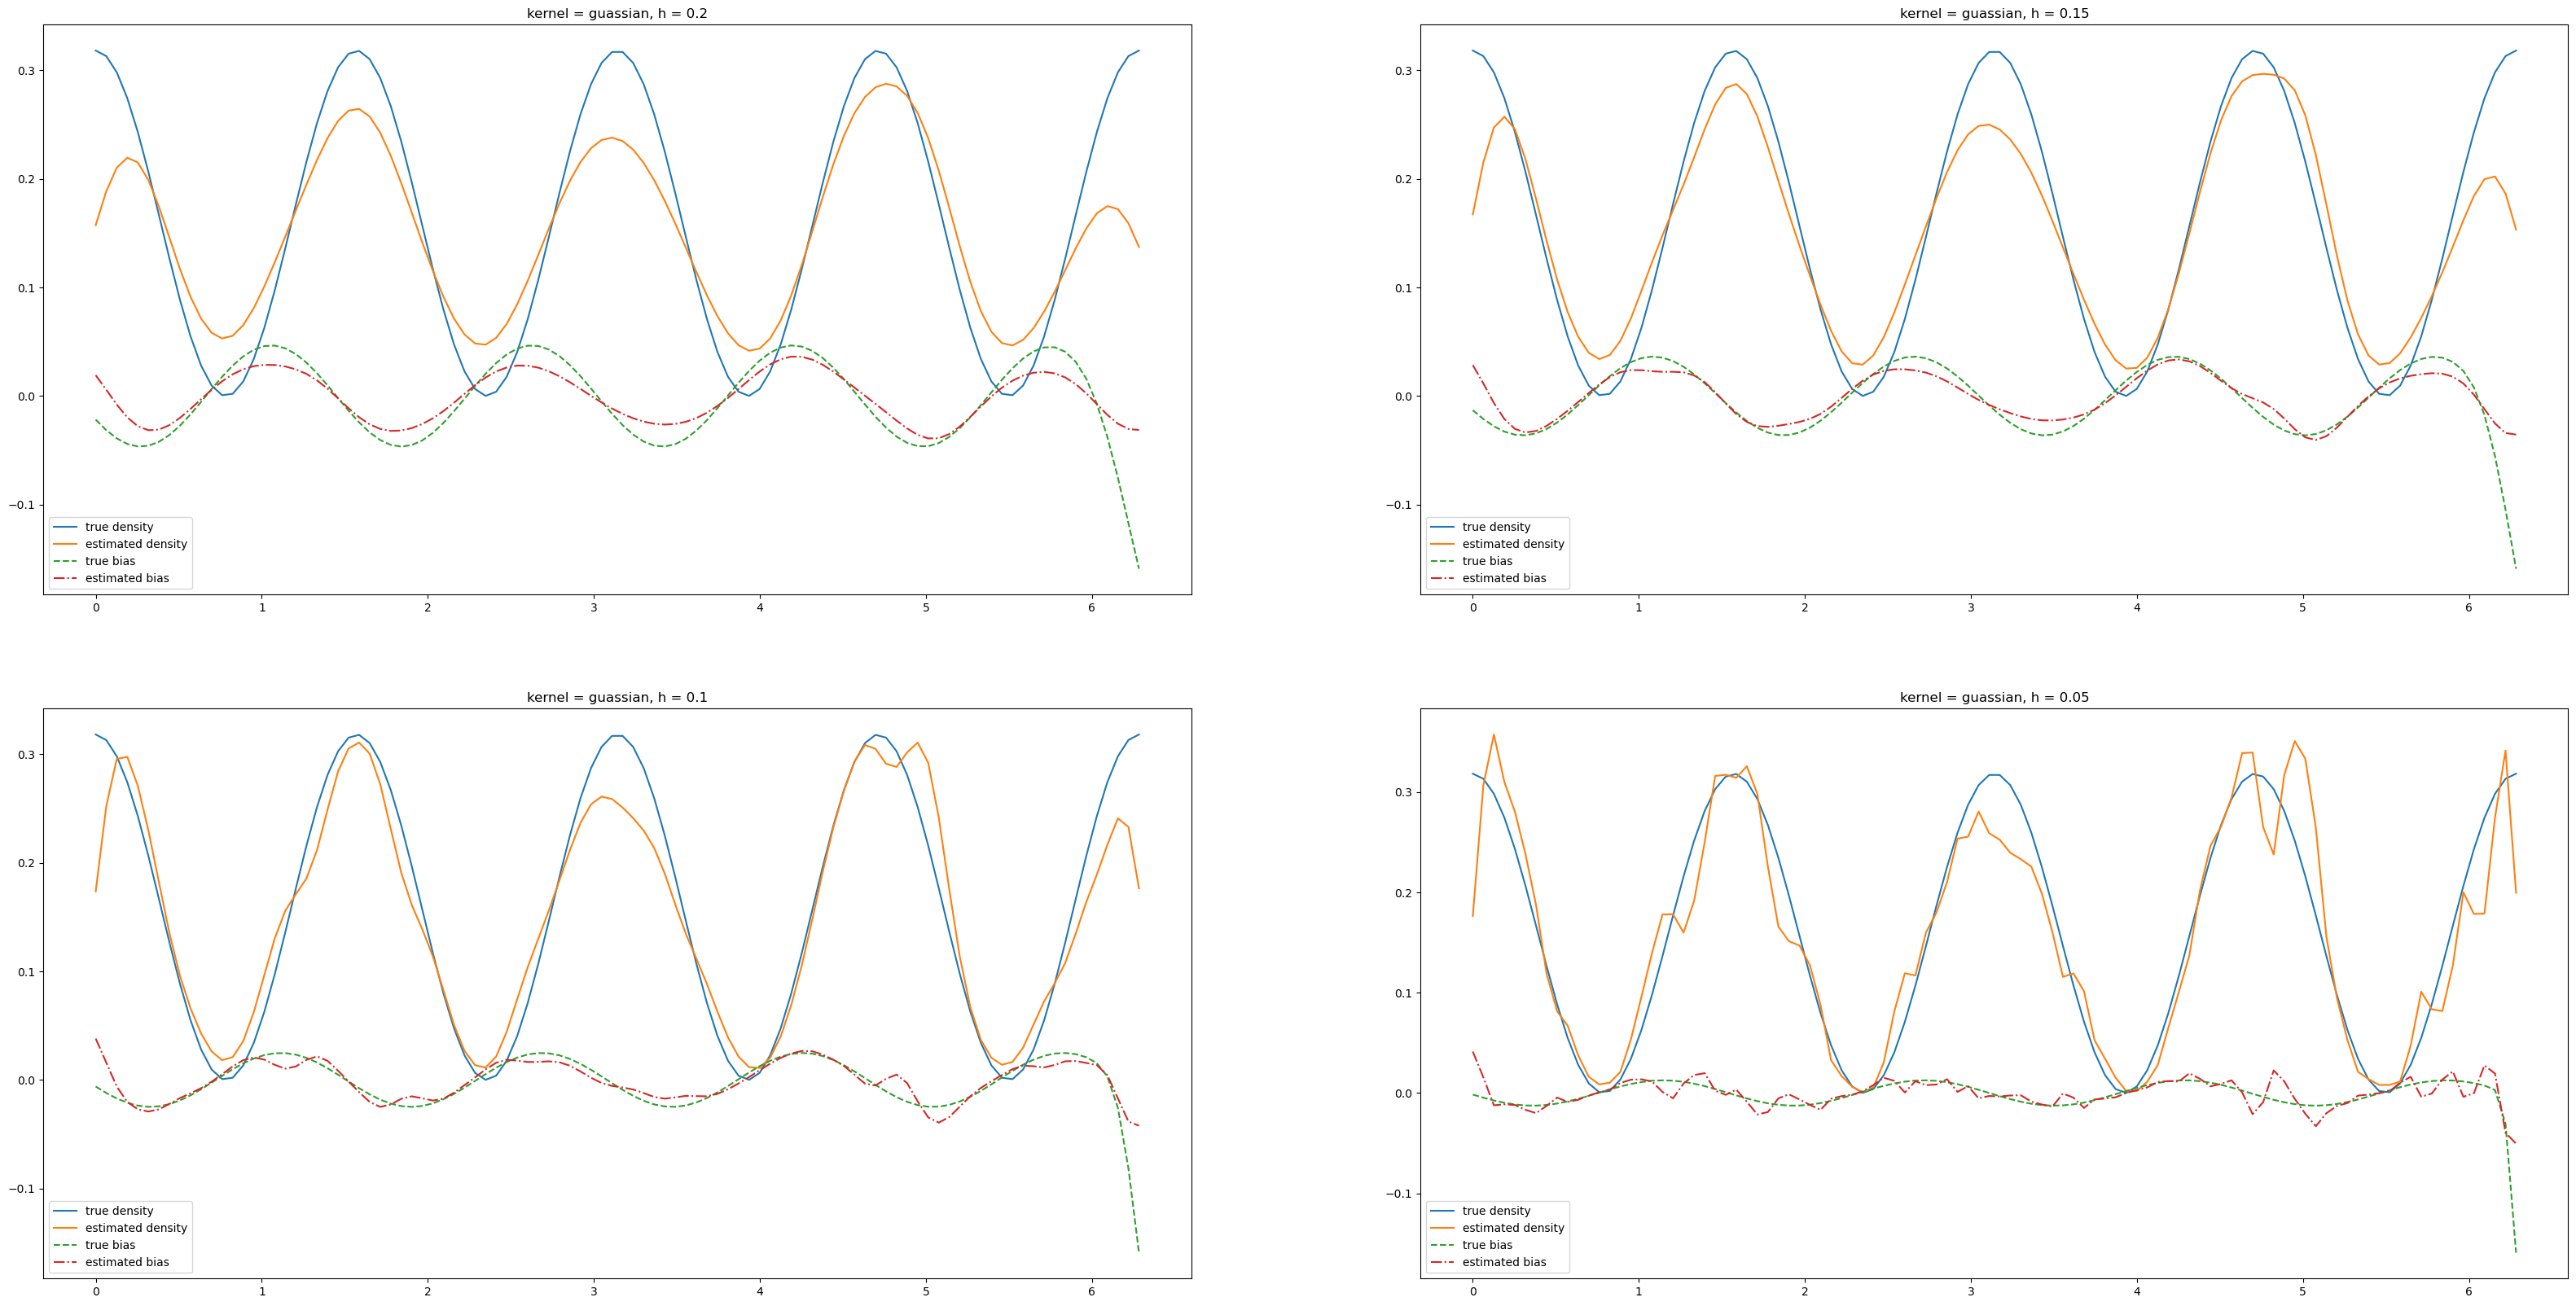

CPU times: total: 21.1 s
Wall time: 52.1 s


In [91]:
%%time
# plot and compare the estimated bias
# here we use guassian as our kernel
fig,ax = plt.subplots(2,2,figsize=(40,20))
random.seed(123) # random seed
S = pd.Series(x.rvs(size=1000)) # sample for estimated denisty

for i,h in zip(range(8),[0.2,0.15,0.1,0.05]): # h means bandwidth
    fhat = kernel_density(S,h,k_g) # estimated density
    row = i//2
    col = i%2
    ax[row,col].plot(V,[f(v) for v in V],label='true density')
    ax[row,col].plot(V,[fhat(v) for v in V],label='estimated density')
    ax[row,col].plot(V,[oracle(v,h,k_g,f)[0] for v in V],label='true bias',ls='--')
    ax[row,col].plot(V,[oracle(v,h,k_g,fhat)[0] for v in V],label='estimated bias',ls='-.')
    ax[row,col].legend(loc='lower left')
    ax[row,col].set_title('kernel = {0}, h = {1}'.format('guassian',h))
plt.show()

From the plot we found the pattern of estimated density and estimated bias are somehow similar.</br>
Hence it might be useful to estimate the bias using $\hat{f}$, however, it would only be useful under the condition that our estimated density is alike to the true density.</br>
This is also the pitfall: we need to estimate the density precisely in order to estimate the bias precisely, otherwise even the positive or negative sign would be wrong sometimes. However, sometimes we need to know the bias to figure out whether we estimate our density precisely! From this term there seems to be a paradox here.